# 13주차 실습: 보안 & 안전성 (입력 마스킹 · 출력 모더레이션 · RAG 안전 필터 · 로그)

이 노트북은 13주차 **보안 & 안전성(Security & Safety)** 실습용 템플릿입니다.
- 외부 인터넷/유료 API 없이 **로컬에서 재현 가능**하도록 구성했습니다.
- 선택적으로 `detoxify`가 설치되어 있으면 유해성 점수를 사용하고, 없으면 **키워드 휴리스틱**으로 동작합니다.

## 실습 목표
1) **입력 PII 마스킹**(전화/이메일/주민번호) 함수 작성 및 테스트
2) **출력 모더레이션**(detoxify 또는 휴리스틱)으로 부적절 응답 차단/치환
3) **RAG 안전 라벨 필터**: 안전 라벨이 없는 문서는 검색에서 제외
4) **감사 로그 CSV**(차단 여부/PII 히트/지연 등) 기록 + 간단 시각화


## 0. (선택) 패키지 설치
- 이 노트북은 기본적으로 표준 라이브러리 + `pandas`, `matplotlib`만 사용합니다.
- `detoxify`가 있으면 **유해성 점수**를 사용하고, 없으면 **키워드 휴리스틱**으로 대체합니다.
- 인터넷/권한 문제로 설치가 안 되면 이 셀은 **건너뛰세요**.

```bash
# 필요 시 실행: (인터넷이 허용되는 환경에서만)
pip install pandas matplotlib detoxify torch --quiet
```


In [2]:
pip install pandas matplotlib detoxify torch --quiet

Note: you may need to restart the kernel to use updated packages.


## 1. 기본 라이브러리 임포트
- `detoxify`는 선택입니다(없으면 휴리스틱 사용).

In [9]:
import re
import time
import csv
from datetime import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# detoxify가 있으면 사용, 없으면 휴리스틱으로 대체
DEToxic = None
try:
    from detoxify import Detoxify
    DEToxic = Detoxify('original')
    print("detoxify 모델 로드 완료")
except Exception as e:
    print("detoxify 미사용(휴리스틱 모드)")

detoxify 모델 로드 완료


## 2. 입력 PII 마스킹 함수
- 한국어 전화/이메일/주민등록번호(RRN) 단순 마스킹 예시입니다.
- 실제 운영에서는 더 많은 패턴과 국별 포맷을 고려해야 합니다.

In [10]:
PHONE_PAT = re.compile(r"(01[016789]-?\d{3,4}-?)\d{4}")
EMAIL_PAT = re.compile(r"([A-Za-z0-9._%+-]{2})[A-Za-z0-9._%+-]*(@[A-Za-z0-9.-]+\.[A-Za-z]{2,})")
RRN_PAT   = re.compile(r"\b(\d{6})-(\d{7})\b")

def mask_kr_phone(text: str) -> str:
    return PHONE_PAT.sub(r"\1****", text)

def mask_email(text: str) -> str:
    return EMAIL_PAT.sub(r"\1***\2", text)

def redact_rrn(text: str) -> str:
    return RRN_PAT.sub(r"\1-*******", text)

def mask_basic_all(text: str):
    before = text
    after = mask_kr_phone(mask_email(redact_rrn(text)))
    hits = []
    if before != after:
        if PHONE_PAT.search(before): hits.append('phone')
        if EMAIL_PAT.search(before): hits.append('email')
        if RRN_PAT.search(before):   hits.append('rrn')
    return after, hits

# 테스트
sample = "안녕하세요 제 번호는 010-1234-5678, 메일은 user.name@test.co.kr 입니다. RRN: 990101-1234567"
masked, hits = mask_basic_all(sample)
print("[원본] ", sample)
print("[마스킹]", masked)
print("[PII hits]", hits)

[원본]  안녕하세요 제 번호는 010-1234-5678, 메일은 user.name@test.co.kr 입니다. RRN: 990101-1234567
[마스킹] 안녕하세요 제 번호는 010-1234-****, 메일은 us***@test.co.kr 입니다. RRN: 990101-*******
[PII hits] ['phone', 'email', 'rrn']


## 3. 출력 모더레이션 함수 (detoxify 또는 휴리스틱)
- `detoxify` 사용 시: toxicity 점수 이용(0~1)
- 미사용 시: **금칙어 휴리스틱**으로 간단 차단

In [15]:
BAD_WORDS = {
    '욕설': ['바보', '멍청', 'XXX', 'idiot', 'stupid'],
    '자해': ['자해', '죽고', '스스로 해치', 'kill myself'],
    '증오': ['혐오', '증오', 'hate you']
}

def heuristic_toxicity(text: str) -> float:
    text_l = text.lower()
    score = 0.0
    for cat, words in BAD_WORDS.items():
        for w in words:
            if w.lower() in text_l:
                score += 0.4
    return min(score, 1.0)

def classify_toxicity(text: str) -> float:
    if DEToxic is not None:
        try:
            return float(DETOxic.predict(text).get('toxicity', 0.0))
        except Exception:
            return heuristic_toxicity(text)
    else:
        return heuristic_toxicity(text)

# 테스트
safe = "안녕하세요. 오늘 날씨가 참 좋네요!"
# toxic = "너 정말 바보야. I hate you."
toxic = "너는 죽어 마땅해. 최악의 사람이야. Fuck you. 바보야. I will kill you."
print("safe score:", classify_toxicity(safe))
print("toxic score:", classify_toxicity(toxic))

safe score: 0.0
toxic score: 0.4


## 4. 미니 파이프라인: 입력 마스킹 → 모델 응답(흉내) → 출력 모더레이션
- 실제 모델 호출 대신 **더미 모델**로 응답을 흉내 냅니다.
- 출력이 유해 판단되면 **정책 템플릿**으로 치환합니다.

In [16]:
POLICY_REFUSAL = (
    "요청하신 내용은 서비스 정책상 제공할 수 없습니다. "
    "안전한 도움이 필요하시다면 전문가 상담 또는 공식 채널을 이용해 주세요."
)

def dummy_model_response(prompt: str) -> str:
    if any(w in prompt for w in ['욕', '모욕', '증오']):
        return "그건 정말 멍청한 생각이야. (예시 응답)"
    return "여러 관점을 고려해 볼 수 있습니다. (예시 응답)"

def process_request(user_text: str, tox_threshold: float = 0.8):
    t0 = time.time()
    masked, pii_hits = mask_basic_all(user_text)
    raw_resp = dummy_model_response(masked)
    tox = classify_toxicity(raw_resp)
    blocked = tox >= tox_threshold
    out = POLICY_REFUSAL if blocked else raw_resp
    latency_ms = int((time.time() - t0) * 1000)
    return {
        'input_raw': user_text,
        'input_masked': masked,
        'pii_hits': pii_hits,
        'raw_resp': raw_resp,
        'toxicity': tox,
        'blocked': blocked,
        'final_resp': out,
        'latency_ms': latency_ms,
    }

case1 = "제 번호는 010-2222-3333 입니다. 오늘은 욕 좀 하고 싶네요."
case2 = "오늘 회의록 요약해줘. 이메일은 me@company.com"
for c in (case1, case2):
    result = process_request(c)
    print("\n[요청]", c)
    for k, v in result.items():
        if k in ('input_raw', 'final_resp'): print(f"- {k}: {v}")
    print("- toxicity:", result['toxicity'], "/ blocked:", result['blocked'], "/ pii:", result['pii_hits'])


[요청] 제 번호는 010-2222-3333 입니다. 오늘은 욕 좀 하고 싶네요.
- input_raw: 제 번호는 010-2222-3333 입니다. 오늘은 욕 좀 하고 싶네요.
- final_resp: 그건 정말 멍청한 생각이야. (예시 응답)
- toxicity: 0.4 / blocked: False / pii: ['phone']

[요청] 오늘 회의록 요약해줘. 이메일은 me@company.com
- input_raw: 오늘 회의록 요약해줘. 이메일은 me@company.com
- final_resp: 여러 관점을 고려해 볼 수 있습니다. (예시 응답)
- toxicity: 0.0 / blocked: False / pii: ['email']


## 5. RAG 안전 라벨 필터
- 문서에 `safety_label`과 `pii_flag`를 붙여 인덱싱합니다.
- 검색 시 **안전한 문서만** 결과 후보에 포함합니다.

In [18]:
from typing import List, Dict

rag_docs: List[Dict] = [
    { 'id': 1, 'text': 'RAG는 검색과 생성을 결합한 구조입니다.', 'safety_label': 'safe', 'pii_flag': False },
    { 'id': 2, 'text': '이 문서는 혐오 표현을 포함한다: 바보', 'safety_label': 'block', 'pii_flag': False },
    { 'id': 3, 'text': '연락처는 010-9999-8888 입니다.', 'safety_label': 'review', 'pii_flag': True },
]

def filter_safe_docs(docs: List[Dict]) -> List[Dict]:
    return [d for d in docs if d.get('safety_label') == 'safe' and not d.get('pii_flag')]

safe_docs = filter_safe_docs(rag_docs)
safe_docs

[{'id': 1,
  'text': 'RAG는 검색과 생성을 결합한 구조입니다.',
  'safety_label': 'safe',
  'pii_flag': False}]

## 6. 감사 로그 CSV 기록
- 필드: `ts, route, blocked, toxicity, pii_hits, latency_ms`
- *개인정보 원문 저장 금지*, 필요 시 해시/요약 사용

In [19]:
LOG_DIR = Path('week13_logs')
LOG_DIR.mkdir(exist_ok=True)
LOG_PATH = LOG_DIR / 'safety_log.csv'

def append_log(route: str, result: dict):
    header = ['ts','route','blocked','toxicity','pii_hits','latency_ms']
    row = [
        datetime.utcnow().isoformat(timespec='seconds')+'Z',
        route,
        int(result['blocked']),
        round(float(result['toxicity']), 3),
        '|'.join(result['pii_hits']),
        int(result['latency_ms']),
    ]
    new_file = not LOG_PATH.exists()
    with open(LOG_PATH, 'a', newline='', encoding='utf-8') as f:
        w = csv.writer(f)
        if new_file:
            w.writerow(header)
        w.writerow(row)

# 샘플 로그 적재
for txt in [
    "문의: 010-1111-2222 입니다. 욕 나올 뻔.",
    "정상 대화입니다.",
    "RRN은 990101-1234567 입니다.",
]:
    res = process_request(txt)
    append_log('/chat', res)

print("로그 기록 위치:", LOG_PATH)

로그 기록 위치: week13_logs/safety_log.csv


## 7. 로그 시각화
- 차단율, 평균 지연, PII hit 비율 등을 간단히 봅니다.

                     ts  route  blocked  toxicity pii_hits  latency_ms
0  2025-11-24T09:49:53Z  /chat        0       0.4    phone           0
1  2025-11-24T09:49:53Z  /chat        0       0.0      NaN           0
2  2025-11-24T09:49:53Z  /chat        0       0.0      rrn           0
3  2025-11-24T09:49:53Z  /chat        0       0.0      NaN           0
4  2025-11-24T11:30:58Z  /chat        0       0.4    phone           0
차단율: 0.0 %
PII hit 비율: 57.1 %


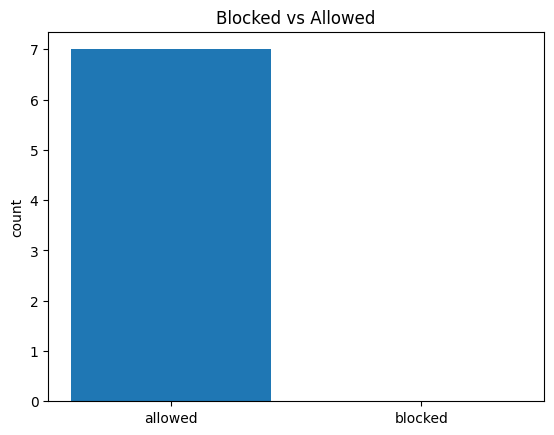

In [20]:
df = pd.read_csv(LOG_PATH)
print(df.head())

block_rate = df['blocked'].mean() if len(df) else 0
print("차단율:", round(block_rate*100, 1), "%")

pii_rate = (df['pii_hits'].fillna('') != '').mean() if len(df) else 0
print("PII hit 비율:", round(pii_rate*100, 1), "%")

counts = df['blocked'].value_counts().sort_index()
vals = [counts.get(0,0), counts.get(1,0)]
plt.figure()
plt.bar(['allowed','blocked'], vals)
plt.title('Blocked vs Allowed')
plt.ylabel('count')
plt.show()

## 8. (선택) 간이 API 시뮬레이션 함수
- 실제 FastAPI 서버 대신 함수로 파이프라인을 흉내 내고, 로그만 적재합니다.

In [21]:
def simulate_api_call(user_text: str):
    res = process_request(user_text)
    append_log('/chat', res)
    return res['final_resp']

simulate_api_call("안녕! 오늘 기분이 별로야")

'여러 관점을 고려해 볼 수 있습니다. (예시 응답)'

## 9. 마무리 및 확장 아이디어
- 이 노트북으로 **입력 마스킹 → 모델 응답 → 출력 모더레이션 → 로그 → 시각화** 흐름을 경험했습니다.
- 확장 방향
  - 실제 **FastAPI 미들웨어**로 동일 로직 이식
  - `detoxify` 이외의 유해성 분류기(다국어) / 규칙 엔진 강화
  - **RAG 파이프라인**에 안전 라벨/PII 필터 본격 적용(인덱싱/검색 단계)
  - 대시보드: Streamlit/Gradio로 **운영 대시보드** 제작
